**Sentiment Analysis with ParsBERT**

In [1]:
#read_data
import pandas as pd
df = pd.read_excel("/content/sample_data/dataset for clustering.xlsx")
df

,Comment,Label
0,شهید بهشتی رو انتخاب کردم چون از هر نظر عالیه,3
1,بعد از تحقیق بسیار، دقیقا بر اساس اساتید بهشتی...,3
2,متاسفانه خیییلی زیاده بی نظمی و اين بده,1
3,واقعا من یک نفر توو دانشگاه بهشتی رضایتی ندارم,1
4,من از نظم خوابگاه راضي نيستم.,1
...,...,...
224,دسترسی به غذا تو دانشگاه هسونه چون تعداد بوفه ...,3
225,غذا های سلف کمیت و کیفیتشون مشکل داره,1
226,کالا کیفیت غذای سلف اکثر دانشگاه ها راضی کننده...,1
227,قوانین موجود در دانشکده کامپیوتر برای دانشجویا...,1


In [2]:
#install packages
!pip install hazm
!pip install clean-text
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 316 kB 5.1 MB/s 
     |████████████████████████████████| 233 kB 66.0 MB/s 
     |████████████████████████████████| 1.4 MB 53.3 MB/s 
  Created wheel for nltk: filename=nltk-3.3-py3-none-any.whl size=1394487 sha256=3c042341a1846dda23f2e03e8369d70c5aec662419dff8f362281add917a238d
  Stored in directory: /root/.cache/pip/wheels/9b/fd/0c/d92302c876e5de87ebd7fc0979d82edb93e2d8d768bf71fac4
  Created wheel for libwapiti: filename=libwapiti-0.2.1-cp37-cp37m-linux_x86_64.whl size=154098 sha256=4708edd440cb0dbb02400a4b1ba7c94bc439df050af482e97d1083681bc62c32
  Stored in directory: /root/.cache/pip/wheels/ab/b2/5b/0fe4b8f5c0e65341e8ea7bb3f4a6ebabfe8b1ac31322392dbf
Successfully built nltk libwapiti
  Attempting uninstall: nltk
    Found existing installation: nltk 3.7
    Uninstalling nltk-3.7:
      Successfully uninstalled nltk-3.7
Looking in indexes: https://

**Imports**

In [3]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.metrics import f1_score, precision_score, recall_score
import numpy as np
import pandas as pd


import plotly.graph_objects as go

from tqdm.notebook import tqdm

import os
import re
import collections

from bs4 import BeautifulSoup
import re
from hazm import *
from cleantext import clean

Since the GPL-licensed package `unidecode` is not installed, using Python's `unicodedata` package which yields worse results.


**Normalization** / **Preprocessing**

In [4]:
def cleaning(text):
    text = text.strip()
    fix_uni = clean(text,
    fix_unicode=True,
    to_ascii=False,
    lower=True,
    no_currency_symbols=True,
    replace_with_number="",
    replace_with_digit="0",
    replace_with_currency_symbol="",
    )
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, '', text)
    rem_url=re.sub(r'http\S+', '',cleantext)
    rem_email = re.sub(r'[A-Za-z0-9]*@[A-Za-z]*\.?[A-Za-z0-9]*', '',rem_url)
    rem_num = re.sub('\b0[1-9]{10}', '', rem_email)
    rem_html = BeautifulSoup(rem_num).get_text()

    emoj = re.compile("["
    u"\U0001F600-\U0001F64F"  # emoticons
    u"\U0001F300-\U0001F5FF"  # symbols & pictographs
    u"\U0001F680-\U0001F6FF"  # transport & map symbols
    u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
    u"\U00002500-\U00002BEF"  # chinese char
    u"\U00002702-\U000027B0"
    u"\U00002702-\U000027B0"
    u"\U000024C2-\U0001F251"
    u"\U0001f926-\U0001f937"
    u"\U00010000-\U0010ffff"
    u"\u2640-\u2642" 
    u"\u2600-\u2B55"
    u"\u200d"
    u"\u23cf"
    u"\u23e9"
    u"\u231a"
    u"\ufe0f"  # dingbats
    u"\u3030"
                  "]+", re.UNICODE)
    rem_emj = re.sub(emoj, '', rem_html)

    rem_nl = re.sub('\n', '', rem_emj)
    rem_sp = re.sub(' +', ' ', rem_nl)
    rem_shrp = re.sub('#', '', rem_sp) 
    
    normalizer = Normalizer()

    norm_txt = normalizer.normalize(rem_shrp)
    
    return norm_txt

In [5]:
df['cleaned_comment'] = df['Comment'].apply(cleaning)

In [6]:
df = df[['cleaned_comment', 'Label']]
df.columns = ['Comment', 'Label']
df.head()

,Comment,Label
0,شهید بهشتی رو انتخاب کردم چون از هر نظر عالیه,3
1,بعد از تحقیق بسیار، دقیقا بر اساس اساتید بهشتی...,3
2,متاسفانه خیییلی زیاده بی نظمی و این بده,1
3,واقعا من یک نفر توو دانشگاه بهشتی رضایتی ندارم,1
4,من از نظم خوابگاه راضی نیستم.,1


**Handling** **Unbalanced Data**

In [7]:
unique_rates = list(sorted(df['Label'].unique()))
print(f'We have #{len(unique_rates)}: {unique_rates}')

We have #2: [1, 3]


In [8]:
fig = go.Figure()

groupby_rate = df.groupby('Label')['Label'].count()

fig.add_trace(go.Bar(
    x=list(sorted(groupby_rate.index)),
    y=groupby_rate.tolist(),
    text=groupby_rate.tolist(),
    textposition='auto'
))

fig.update_layout(
    title_text='Distribution of rate within comments',
    xaxis_title_text='Label',
    yaxis_title_text='Frequency',
    bargap=0.2,
    bargroupgap=0.2)

fig.show()

In [9]:
for i,row in df.iterrows():
    if row['Label'] < 3:
      df.at[i,'Label'] = 0
    else:
      df.at[i,'Label'] = 1
df['Label'] = df['Label'].map({1:'positive', 0:'negative'}) 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [10]:
df

,Comment,Label
0,شهید بهشتی رو انتخاب کردم چون از هر نظر عالیه,positive
1,بعد از تحقیق بسیار، دقیقا بر اساس اساتید بهشتی...,positive
2,متاسفانه خیییلی زیاده بی نظمی و این بده,negative
3,واقعا من یک نفر توو دانشگاه بهشتی رضایتی ندارم,negative
4,من از نظم خوابگاه راضی نیستم.,negative
...,...,...
224,دسترسی به غذا تو دانشگاه هسونه چون تعداد بوفه‌...,positive
225,غذا‌های سلف کمیت و کیفیتشون مشکل داره,negative
226,کالا کیفیت غذای سلف اکثر دانشگاه‌ها راضی کننده...,negative
227,قوانین موجود در دانشکده کامپیوتر برای دانشجویا...,negative


labels after balancing : Counter({'negative': 145, 'positive': 84})
labels after balancing : Counter({'positive': 145, 'negative': 145})


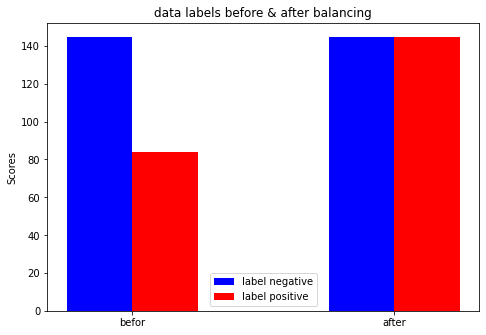

In [11]:
from imblearn.over_sampling import RandomOverSampler
from collections import Counter
import matplotlib.pyplot as plt

print(f"labels after balancing : {Counter(df['Label'])}")

unbalanced_labels = dict(Counter(df['Label']))

over_sampler = RandomOverSampler(random_state=42)
X_res, y_res = over_sampler.fit_resample(df['Comment'].values.reshape(-1, 1),df['Label'])

print(f"labels after balancing : {Counter(y_res)}")

balanced_labels = dict(Counter(y_res))

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
X = np.arange(4)


width = 0.25  
bar1 = ax.bar([0,1],[unbalanced_labels['negative'], balanced_labels['negative']] ,color = 'b', width = width,align='center')
bar2 = ax.bar([0+width,1+width] ,[unbalanced_labels['positive'], balanced_labels['positive']] ,color = 'r', width = width,align='center')

ax.set_ylabel('Scores')
ax.set_title('data labels before & after balancing')
ax.set_xticks([0 + width / 2, 1 + width / 2]  )
ax.set_xticklabels(('befor', 'after') )

ax.legend( (bar1[0], bar2[0]), ('label negative', 'label positive') )


**Train**,**Validation**,**Test** **split**

In [12]:
new_data = pd.DataFrame(list(zip(X_res, y_res)),
               columns =['comment', 'label'])
new_data
new_data.to_excel(r'/content/sample_data\new-data.xlsx', index = False)

In [13]:
labels = ['negative', 'positive']
new_data['label_id'] = new_data['label'].apply(lambda t: labels.index(t))

train, test = train_test_split(new_data, test_size=0.1, random_state=1, stratify=new_data['label'])
train, valid = train_test_split(train, test_size=0.1, random_state=1, stratify=train['label'])

train = train.reset_index(drop=True)
valid = valid.reset_index(drop=True)
test = test.reset_index(drop=True)

x_train, y_train = train['comment'].values.tolist(), train['label_id'].values.tolist()
x_valid, y_valid = valid['comment'].values.tolist(), valid['label_id'].values.tolist()
x_test, y_test = test['comment'].values.tolist(), test['label_id'].values.tolist()

print(train.shape)
print(valid.shape)
print(test.shape)

(234, 3)
(27, 3)
(29, 3)


**Pytorch**

In [14]:
# Import required packages 
from transformers import BertConfig, BertTokenizer
from transformers import BertModel

import torch
import torch.nn as nn
import torch.nn.functional as F

**Configuration**

In [15]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f'device: {device}')

train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

device: cuda:0
CUDA is available!  Training on GPU ...


In [33]:
# general config
MAX_LEN = 128
TRAIN_BATCH_SIZE = 3
VALID_BATCH_SIZE = 3
TEST_BATCH_SIZE = 3

EPOCHS = 10
EEVERY_EPOCH = 1000
LEARNING_RATE = 2e-5
CLIP = 0.0
MODEL_PATH = 'HooshvareLab/bert-fa-base-uncased'
OUTPUT_PATH = '/content/bert-fa-base-uncased-sentiment-analysis/pytorch_model.bin'

os.makedirs(os.path.dirname(OUTPUT_PATH), exist_ok=True)

In [34]:
# create a key finder based on label 2 id and id to label

label2id = {label: i for i, label in enumerate(labels)}
id2label = {v: k for k, v in label2id.items()}

print(f'label2id: {label2id}')
print(f'id2label: {id2label}')

label2id: {'negative': 0, 'positive': 1}
id2label: {0: 'negative', 1: 'positive'}


**Setup** **the** **Tokenizer** **and** **Configuration**

In [35]:
tokenizer = BertTokenizer.from_pretrained(MODEL_PATH)
config = BertConfig.from_pretrained(MODEL_PATH,
                                    **{'label2id': label2id,
                                       'id2label': id2label,})

**Input** **Embeddings**
**of** **Dataset**

In [36]:
class Dataset(torch.utils.data.Dataset):

    def __init__(self, tokenizer, comments, targets=None, label_list=None, max_len=128):
        self.comments = comments
        self.targets = targets
        self.has_target = isinstance(targets, list) or isinstance(targets, np.ndarray)

        self.tokenizer = tokenizer
        self.max_len = max_len

        
        self.label_map = {label: i for i, label in enumerate(label_list)} if isinstance(label_list, list) else {}
    
    def __len__(self):
        return len(self.comments)

    def __getitem__(self, item):
        comment = str(self.comments[item])

        if self.has_target:
            target = self.label_map.get(str(self.targets[item]), str(self.targets[item]))

        encoding = self.tokenizer.encode_plus(
            comment,
            add_special_tokens=True,
            truncation=True,
            max_length=self.max_len,
            return_token_type_ids=True,
            padding='max_length',
            return_attention_mask=True,
            return_tensors='pt')
        
        inputs = {
            'comment': comment,
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'token_type_ids': encoding['token_type_ids'].flatten(),
        }

        if self.has_target:
            inputs['targets'] = torch.tensor(target, dtype=torch.long)
        
        return inputs


def create_data_loader(x, y, tokenizer, max_len, batch_size, label_list):
    dataset = Dataset(
        comments=x,
        targets=y,
        tokenizer=tokenizer,
        max_len=max_len, 
        label_list=label_list)
    
    return torch.utils.data.DataLoader(dataset, batch_size=batch_size)

In [37]:
label_list = ['negative', 'positive']
train_data_loader = create_data_loader(train['comment'].to_numpy(), train['label'].to_numpy(), tokenizer, MAX_LEN, TRAIN_BATCH_SIZE, label_list)
valid_data_loader = create_data_loader(valid['comment'].to_numpy(), valid['label'].to_numpy(), tokenizer, MAX_LEN, VALID_BATCH_SIZE, label_list)
test_data_loader = create_data_loader(test['comment'].to_numpy(), None, tokenizer, MAX_LEN, TEST_BATCH_SIZE, label_list)

**Model**

In [38]:
class SentimentModel(nn.Module):

    def __init__(self, config):
        super(SentimentModel, self).__init__()

        self.bert = BertModel.from_pretrained(MODEL_PATH)
        self.dropout = nn.Dropout(config.hidden_dropout_prob)
        self.classifier = nn.Linear(config.hidden_size, config.num_labels)
    
    def forward(self, input_ids, attention_mask, token_type_ids):
        _,bert_out = self.bert(
          input_ids=input_ids, 
          attention_mask=attention_mask, 
          token_type_ids=token_type_ids,
          return_dict = False)
        dopuot_out = self.dropout(bert_out)
        classifier_out = self.classifier(dopuot_out)
        return classifier_out 

In [39]:
import torch, gc

gc.collect()
torch.cuda.empty_cache()
pt_model = None

!nvidia-smi

Fri Jul 15 12:53:55 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   50C    P0    29W /  70W |   3622MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [40]:
pt_model = SentimentModel(config=config)
pt_model = pt_model.to(device)

print('pt_model', type(pt_model))

Some weights of the model checkpoint at HooshvareLab/bert-fa-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


pt_model <class '__main__.SentimentModel'>


**Training**

In [41]:
from sklearn.metrics import accuracy_score, f1_score
def acc_and_f1(y_true, y_pred, average='weighted'):
    accuracy = accuracy_score(y_true, y_pred)

    f1 = f1_score(y_true, y_pred, average=average)

    return {
        "acc": accuracy,
        "f1": f1,
    }

def y_loss(y_true, y_pred, losses):
    y_true = torch.stack(y_true).cpu().detach().numpy()
    y_pred = torch.stack(y_pred).cpu().detach().numpy()
    y = [y_true, y_pred]
    loss = np.mean(losses)

    return y, loss


def eval_op(model, data_loader, loss_fn):
    model.eval()

    losses = []
    y_pred = []
    y_true = []

    with torch.no_grad():
        for dl in tqdm(data_loader, total=len(data_loader), desc="Evaluation... "):

            input_ids = dl['input_ids']
            attention_mask = dl['attention_mask']
            token_type_ids = dl['token_type_ids']
            targets = dl['targets']


            # move tensors to GPU if CUDA is available
            input_ids = input_ids.to(device)
            attention_mask = attention_mask.to(device)
            token_type_ids = token_type_ids.to(device)
            targets = targets.to(device)

            # compute predicted outputs by passing inputs to the model
            model_output = model(input_ids=input_ids, attention_mask=attention_mask,
                                  token_type_ids=token_type_ids)
            
            # convert output probabilities to predicted class
            _, preds = torch.max(model_output, dim=1)

            # calculate the batch loss
            loss = loss_fn(model_output, targets)

            # accumulate all the losses
            losses.append(loss.item())

            y_pred.extend(preds)
            y_true.extend(targets)
    
    eval_y, eval_loss = y_loss(y_true, y_pred, losses)
    return eval_y, eval_loss


def train_op(model, 
             data_loader, 
             loss_fn, 
             optimizer, 
             scheduler, 
             step=0, 
             print_every_step=100, 
             eval=False,
             eval_cb=None,
             eval_loss_min=np.Inf,
             eval_data_loader=None, 
             clip=0.0):
    
    model.train()

    losses = []
    y_pred = []
    y_true = []

    for dl in tqdm(data_loader, total=len(data_loader), desc="Training... "):
        step += 1

        # Define input_ids, attention_mask, token_type_ids, targets
        input_ids = dl['input_ids']
        attention_mask = dl['attention_mask']
        token_type_ids = dl['token_type_ids']
        targets = dl['targets']

        # move tensors to GPU if CUDA is available
        input_ids = input_ids.to(device)
        attention_mask = attention_mask.to(device)
        token_type_ids = token_type_ids.to(device)
        targets = targets.to(device)

        # clear the gradients of all optimized variables
        optimizer.zero_grad()

        # compute predicted outputs by passing inputs to the model
        model_output = model(input_ids=input_ids, attention_mask=attention_mask,
                                  token_type_ids=token_type_ids)
        # convert output probabilities to predicted class
        _, preds = torch.max(model_output, dim=1)

        # calculate the batch loss
        loss = loss_fn(model_output, targets)

        # accumulate all the losses
        losses.append(loss.item())

        # compute gradient of the loss with respect to model parameters
        loss.backward()

        # `clip_grad_norm` helps prevent the exploding gradient problem in RNNs / LSTMs.
        if clip > 0.0:
            nn.utils.clip_grad_norm_(model.parameters(), max_norm=clip)

        # perform optimization step
        optimizer.step()

        # perform scheduler step
        scheduler.step()

        y_pred.extend(preds)
        y_true.extend(targets)

        if eval:
            train_y, train_loss = y_loss(y_true, y_pred, losses)
            train_score = acc_and_f1(train_y[0], train_y[1], average='weighted')

            if step % print_every_step == 0:
                eval_y, eval_loss = eval_op(model, eval_data_loader, loss_fn)
                eval_score = acc_and_f1(eval_y[0], eval_y[1], average='weighted')

                if hasattr(eval_cb, '__call__'):
                    eval_loss_min = eval_cb(model, step, train_score, train_loss, eval_score, eval_loss, eval_loss_min)

    train_y, train_loss = y_loss(y_true, y_pred, losses)

    return train_y, train_loss, step, eval_loss_min

In [42]:
from transformers import AdamW
from transformers import get_linear_schedule_with_warmup

optimizer = AdamW(pt_model.parameters(), lr=LEARNING_RATE, correct_bias=False)
total_steps = len(train_data_loader) * EPOCHS
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=total_steps
)

loss_fn = nn.CrossEntropyLoss() 

step = 0
eval_loss_min = np.Inf
history = collections.defaultdict(list)


def eval_callback(epoch, epochs, output_path):
    def eval_cb(model, step, train_score, train_loss, eval_score, eval_loss, eval_loss_min):
        statement = ''
        statement += 'Epoch: {}/{}...'.format(epoch, epochs)
        statement += 'Step: {}...'.format(step)
        
        statement += 'Train Loss: {:.6f}...'.format(train_loss)
        statement += 'Train Acc: {:.3f}...'.format(train_score['acc'])

        statement += 'Valid Loss: {:.6f}...'.format(eval_loss)
        statement += 'Valid Acc: {:.3f}...'.format(eval_score['acc'])

        print(statement)

        if eval_loss <= eval_loss_min:
            print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
                eval_loss_min,
                eval_loss))
            
            torch.save(model.state_dict(), output_path)
            eval_loss_min = eval_loss
        
        return eval_loss_min


    return eval_cb

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning:

This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning



In [43]:
for epoch in tqdm(range(1, EPOCHS + 1), desc="Epochs... "):

    # Define train_y, train_loss, step, eval_loss_min using train_op
    train_y, train_loss, step, eval_loss_min = train_op(
        model=pt_model, 
        data_loader=train_data_loader, 
        loss_fn=loss_fn, 
        optimizer=optimizer, 
        scheduler=scheduler, 
        step=step, 
        print_every_step=EEVERY_EPOCH, 
        eval=True,
        eval_cb=eval_callback(epoch, EPOCHS, OUTPUT_PATH),
        eval_loss_min=eval_loss_min,
        eval_data_loader=valid_data_loader, 
        clip=CLIP)
    
    # Define train_score using acc_and_f1
    train_score = acc_and_f1(train_y[0], train_y[1], average='weighted')
    
    # Define eval_y, eval_loss using eval_op
    eval_y, eval_loss = eval_op(
        model=pt_model, 
        data_loader=valid_data_loader, 
        loss_fn=loss_fn)
    
    # Define eval_score using acc_and_f1
    eval_score = acc_and_f1(eval_y[0], eval_y[1], average='weighted')

    print(train_score['acc'])
    print(eval_score['acc'])
    
    # Save Accuracy and Loss values
    history['train_acc'].append(train_score['acc'])
    history['train_loss'].append(train_loss)
    history['val_acc'].append(eval_score['acc'])
    history['val_loss'].append(eval_loss)

Epochs... :   0%|          | 0/10 [00:00<?, ?it/s]

Training... :   0%|          | 0/78 [00:00<?, ?it/s]

Evaluation... :   0%|          | 0/9 [00:00<?, ?it/s]

0.7264957264957265
0.8888888888888888


Training... :   0%|          | 0/78 [00:00<?, ?it/s]

Evaluation... :   0%|          | 0/9 [00:00<?, ?it/s]

0.9529914529914529
0.8888888888888888


Training... :   0%|          | 0/78 [00:00<?, ?it/s]

Evaluation... :   0%|          | 0/9 [00:00<?, ?it/s]

0.9914529914529915
0.9259259259259259


Training... :   0%|          | 0/78 [00:00<?, ?it/s]

Evaluation... :   0%|          | 0/9 [00:00<?, ?it/s]

0.9957264957264957
0.9259259259259259


Training... :   0%|          | 0/78 [00:00<?, ?it/s]

Evaluation... :   0%|          | 0/9 [00:00<?, ?it/s]

0.9957264957264957
0.9629629629629629


Training... :   0%|          | 0/78 [00:00<?, ?it/s]

Evaluation... :   0%|          | 0/9 [00:00<?, ?it/s]

0.9957264957264957
0.9629629629629629


Training... :   0%|          | 0/78 [00:00<?, ?it/s]

Evaluation... :   0%|          | 0/9 [00:00<?, ?it/s]

1.0
0.9629629629629629


Training... :   0%|          | 0/78 [00:00<?, ?it/s]

Evaluation... :   0%|          | 0/9 [00:00<?, ?it/s]

1.0
0.9629629629629629


Training... :   0%|          | 0/78 [00:00<?, ?it/s]

Evaluation... :   0%|          | 0/9 [00:00<?, ?it/s]

1.0
0.9629629629629629


Training... :   0%|          | 0/78 [00:00<?, ?it/s]

Evaluation... :   0%|          | 0/9 [00:00<?, ?it/s]

1.0
0.9629629629629629


Text(0.5, 0, 'Epochs')

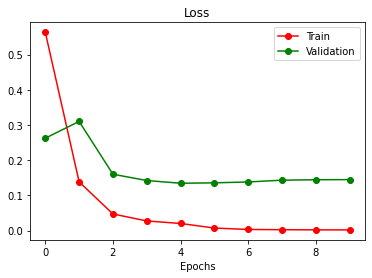

In [44]:
plt.figure()
plt.plot(history['train_loss'], "ro-", label="Train")
plt.plot(history['val_loss'], "go-", label="Validation")
plt.legend()
plt.title("Loss")
plt.xlabel("Epochs")

Text(0.5, 0, 'Epochs')

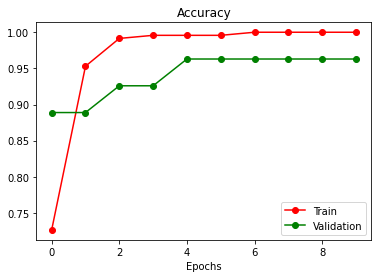

In [45]:
plt.figure()
plt.plot(history['train_acc'], "ro-", label="Train")
plt.plot(history['val_acc'], "go-", label="Validation")
plt.legend()
plt.title("Accuracy")
plt.xlabel("Epochs")

**Prediction**

In [46]:
def predict(model, comments, tokenizer, max_len=128, batch_size=32):
    data_loader = create_data_loader(comments, None, tokenizer, max_len, batch_size, None)
    
    predictions = []
    prediction_probs = []

    
    model.eval()
    with torch.no_grad():
        for dl in tqdm(data_loader, position=0):

            # Define input_ids, attention_mask, token_type_ids
            input_ids = dl['input_ids']
            attention_mask = dl['attention_mask']
            token_type_ids = dl['token_type_ids']

            # move tensors to GPU if CUDA is available
            input_ids = input_ids.to(device)
            attention_mask = attention_mask.to(device)
            token_type_ids = token_type_ids.to(device)
            
            # compute predicted outputs by passing inputs to the model
            model_output = model(input_ids=input_ids, attention_mask=attention_mask,
                                  token_type_ids=token_type_ids)
            
            # convert output probabilities to predicted class
            _, preds = torch.max(model_output, dim=1)

            predictions.extend(preds)
            prediction_probs.extend(F.softmax(model_output, dim=1))

    predictions = torch.stack(predictions).cpu().detach().numpy()
    prediction_probs = torch.stack(prediction_probs).cpu().detach().numpy()

    return predictions, prediction_probs

In [47]:
test_comments = test['comment'].to_numpy()
preds, probs = predict(pt_model, test_comments, tokenizer, max_len=128)

print(preds.shape, probs.shape)


  0%|          | 0/1 [00:00<?, ?it/s]

(29,) (29, 2)


**Evaluation**

In [48]:
f1 = f1_score(y_test, preds)
precision =precision_score(y_test, preds)
recall = recall_score(y_test, preds)

print('calculated f1 score = {}'.format(f1))
print('calculated precision score = {}'.format(precision))
print('calculated recall score = {}'.format(recall))

calculated f1 score = 0.9285714285714286
calculated precision score = 1.0
calculated recall score = 0.8666666666666667
